# Replication Michael P. Keane & Kenneth I. Wopin

This notebook replicates results from: 

Keane, M. P. & Wopin, W. I. (1997). [The career Decisions of Young Men.](https://www.jstor.org/stable/10.1086/262080)
 *Journal of Political Economy, 105(3): 473-552.*

The above mentioned paper builds on the theoratical paper from:

Keane, M. P. & Wopin, W. I., & Vytlacil, E. J. (1994). 
[The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence.](https://www.jstor.org/stable/2109768)
 *The Review of Economics and Statistics, 76(4): 648-672.*

For this purpose l rely on the  *respy* and *estimagic* open-source python packages. [*Respy*](https://github.com/OpenSourceEconomics/respy) is for the simulation and estimation of a prototypical finite-horizon discrete choice dynamic programming model and [*Estimagic*](https://github.com/OpenSourceEconomics/estimagic) helps to build high-quality and user friendly implementations of (structural) econometric models.

In section 1, l talk about the groundwork that l have done in preperation for replicating KW1997. I talk also about the authors' motivation and show the theoratical framework behind the paper. In keeping with the fundamentals of the course, l develop a causal framework for the discrete choice dynamic programming model. I load the data and create several plots that help us to understand what the data represents with respect to the variables within the dataset in section 2. It should be kept in mind whilst interpreting the graphs, that as the number of periods increase, sample attrition that plays a role. I then reproduce the main reslults in section 3 using the *respy* and *estimagic* packages and calculate standard errors for the estimated parameters. In section 4, l discuss the results of the paper and my thoughts on some avenues for possible extension which inturn concludes my contribution to the replication of KW1997.


# Section 1: Background

#### Groundwork 

This project builds upon collaboration and contributions to the *respy* and *estimagic* open source packages. In particular, l have worked with some of the open source contributors of these packages to develop parts of the code.

For the *respy* package, l have integrated the results of a project l previously completed on [benchmarking various implementations of ols and iv ](https://github.com/lindamaok899/least_squares). This was done to drop all statsmodels dependencies in the package in favor of incorporating a faster method of calculating ols estimates. I have also integrated a root mean squared error (rmse) function in the package for the same purpose.

For the *estimagic* package, l have worked on the documentation of the numerical optimisers used in the package. In particular, l have created reference dictionaries for the different arguments that relate to the various implemented numerical optimizers.

For both packages and an additional project (*uncertainty quantification project*), l have also calculated standard errors for parameter estimates of likelihood models. More specifically, l write functions that construct the full covariance matrix of the estimated parameters. There are different ways to calculate those covariance matrices, but in all cases they are based on derivatives of the log likelihood function. I have also written a function that extracts the diagonal elements of these covariance matrices to contstuct a 1d array of containing the standard errors. After this, l have written a benchmarking module that compares the functions to the statsmodels output to ensure complete accuracy of the covariance matrices. Lastly, l have written tests to all the encorprated functions. The under-the-hood workings of this part of my assignment can be viewed in the estimagic repository under open source economics [here](https://github.com/OpenSourceEconomics/estimagic/tree/master/estimagic/inference). Subsequently, l will encorporate the neccesary functions for the replication in the auxilliary folder if neccesary.


#### Authors' motivation

This paper provides structural estimates of schooling, work and occupational choice decisions based on 11 years of observations on a sample of 1373 white young men from the 1979 youth cohort of the National Longitudinal Surveys of Labor Market Experience (NLSY). The authors ingeminate the importance of encorporating self selection for an accurate assessment of the differential productivity of human capital investment. In their paper, they extend earlier (prior to 1997) work done in the this field by considering self-selection in the three dimensions of schooling, work and occupational choice. More specifically, they extend the static deterministic setting of earlier models (Heckman and Sedlacek, 1985; Willis, 1986), each of which is an extension of the basic Roy (1951) framework, to a model in which decision making is sequential and the environment is uncertain.

The structural approach in Keane and Wopin (1997) provides rigorous interpretations for the parameters that are estimated, which has several important implications for ex-ante policy evaluation such as:

1) predicting the effect an intervention that provides college tuition subsidies has on college attendance rates and subsequent occupational choice decisions

2) assessing the welfare effects of interventions on lifetime wealth and utility, allowing policy makers to draw distributional consequences of them 

To implement the model, the participants are assigned in each year to one of five discrete, mutually exclusive alternatives: attending school, working in a white collar occupation, working in a blue collar occupation, working in the military or engaging on home production.

#### Theoretical framework

#### Causal Graph representation

# Section 2: Data & Visualisation

#### Data loaading and pre-proccessing

I first conduct some basic preperation of the data to increase readability.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from auxiliary.auxiliary import *
import warnings

warnings.filterwarnings("ignore", "This figure includes Axes that are not compatible")



In [2]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('ticks')

# Ensure proper formatting of the wage variable
pd.options.display.float_format = '{:,.2f}'.format

# Label and format the different columns
columns = ['Identifier', 'Age', 'Schooling', 'Choice', 'Wage']
dtype = {'Identifier': np.int, 'Age': np.int,  'Schooling': np.int,  'Choice': 'category'}

# Read the original data file
df = pd.DataFrame(np.genfromtxt('data/KW_97.raw'), columns=columns).astype(dtype)

# Label the different choice categories
df['Choice'].cat.categories = ['Schooling', 'Home', 'White', 'Blue', 'Military']

# Set the index for easier interpretability
df['Period'] = df['Age'] - 16
df.set_index(['Identifier', 'Period'], inplace=True, drop=True)

#### Data description

All individuals enter the model initially at the same age and are then observed for a varying number of consecutive years. Each year, the individual's decision to work in either a white or blue collar occupation, attend school, enroll in the miliary, or remain at home is recorded. If the individual is working, the dataset potentially also contains that year's wage as a full-time equivalent. As can be seen from the replication of table 1 below, there is considerable missing wage information, particularly at the younger ages and for blue collar employment.

In [3]:
# preview the data
df.head()

Age  Schooling     Choice  Wage
Identifier Period                                 
6          0        16         11  Schooling   nan
           1        17         12  Schooling   nan
           2        18         13  Schooling   nan
           3        19         14  Schooling   nan
           4        20         15  Schooling   nan

In [4]:
df_unindexed = df.reset_index().rename(columns={0:'value'})
df_unindexed.head()

,Identifier,Period,Age,Schooling,Choice,Wage
0,6,0,16,11,Schooling,nan
1,6,1,17,12,Schooling,nan
2,6,2,18,13,Schooling,nan
3,6,3,19,14,Schooling,nan
4,6,4,20,15,Schooling,nan


#### Sample size distribution by age

The sample size seems to decrease as the periods increase, most likely attributable to sample attrition.

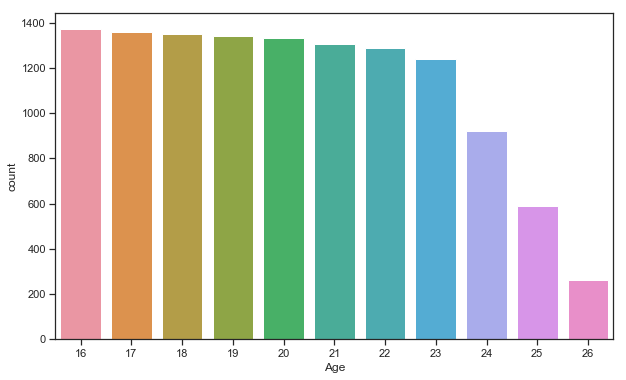

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(df['Age'])
plt.show()

##### Years of schooling in initial period
This plot illustrates the given level of schooling at age 16. 

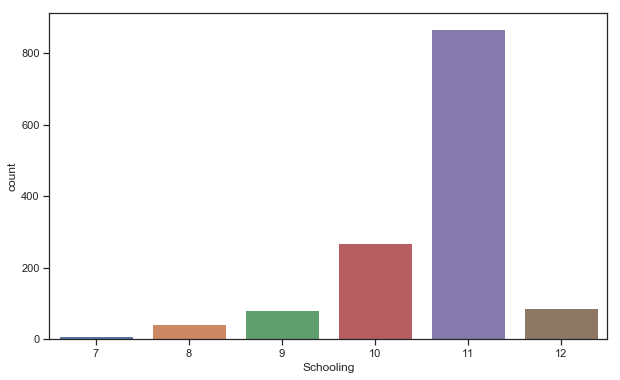

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
initial_period = df_unindexed[(df_unindexed['Period'].isin(['1']))]
sns.countplot(initial_period['Schooling'])
plt.show()

#### Wages

The figures below show that occupation-specific wage is increasing in age and years of experience. Returns to schooling are larger in white-collar jobs. While the initial wage is lower, it does increase rapidly with schooling compared as compared to the blue-collar proffessions.

##### Average real wage by occupation as in Table 4
The table shows age-specific average real wages overall and by occupation. White- and blue-collar occupations are very similar through age 21. However, after this age, white-collar wages are, on average, about 20 percent higher. Military ages are the lowest at all ages. 

In [7]:
tab = pd.crosstab(index=df['Age'], columns=df['Choice'], values=df['Wage'], aggfunc='mean', margins=True)
tab[['All', 'White', 'Blue', 'Military']]

Choice,All,White,Blue,Military
Age,,,,
16,"10,217.74","9,320.76","10,286.74",nan
17,"11,036.60","10,049.76","11,572.89","9,005.36"
18,"12,060.75","11,775.34","12,603.82","10,171.87"
19,"12,246.68","12,376.42","12,949.84","9,714.60"
20,"13,635.87","13,824.01","14,363.66","10,852.51"
21,"14,977.00","15,578.14","15,313.45","12,619.37"
22,"17,561.28","20,236.08","16,947.90","13,771.56"
23,"18,719.84","20,745.56","17,884.95","14,868.65"
24,"20,942.42","24,066.64","19,245.19","15,910.84"


We see in the plot below that occupational choices exhibit persistence.

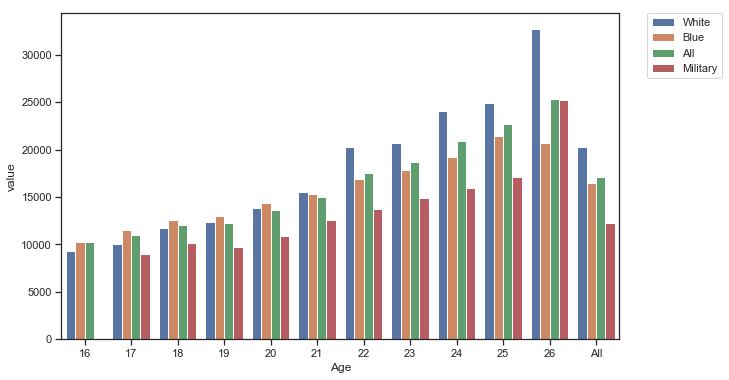

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
stacked = tab.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked.Age, y=stacked.value, hue=stacked.Choice)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

##### Real wage per period within the choice set

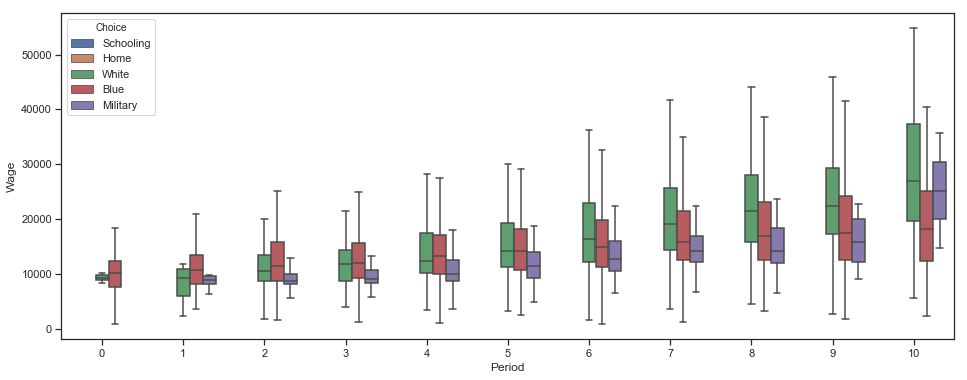

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
# This box plox excludes outliers from the data via the Showfliers=False command
#ensures better visibility of the data
sns.boxplot(x="Period", y="Wage", data=df_unindexed, hue="Choice", showfliers=False)
plt.show()

##### Relaitonship between wage and years of schooling

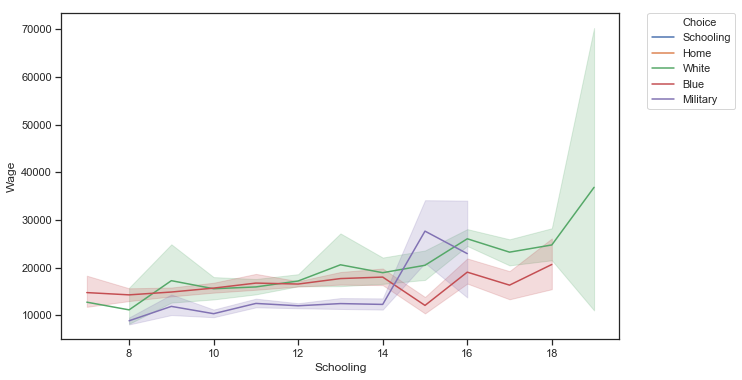

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="Schooling", y="Wage", hue="Choice", data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Choice

This part shows graphically, different attributes of the choices to illustrate the variables in the dataset.

The figures below illustrate that (i) school attendance should decline with age, and that (ii) employment should increase with age. We see that participation in both white- and blue-collar occupations increase monotonically, but at different rates. What is noteworthy is that participation in blue-collar occupations is essentially unchanged after age 22, whereas white collar participation almost doubles between ages 22 and 25. It is evident from the graphs, that there is a close connection between leaving school at college-going ages and moving into white-collar employment. In contrast to civillian occupations, participating in the military quickly increases to a peak at age 20, then declines at about age 25.

##### Number of individuals per choice

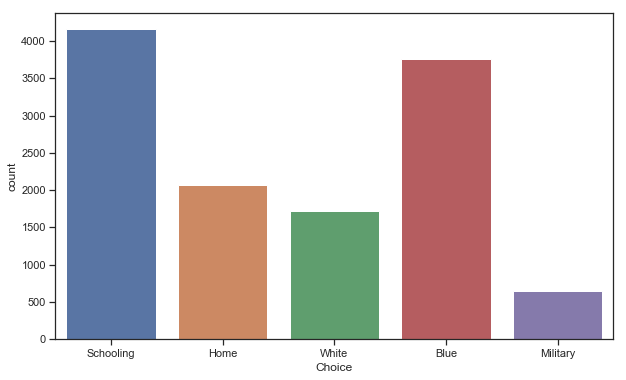

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(df['Choice'])
plt.show()

##### Average age by choice

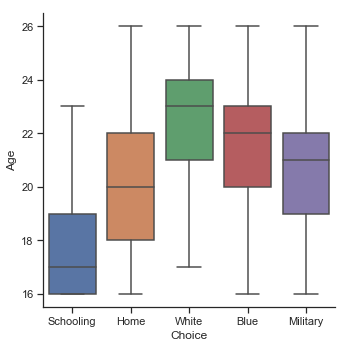

In [12]:
# Outliers excluded from this plot, to include them showfliers=True
sns.catplot(x="Choice", y="Age", kind="box", data=df, showfliers=False)
plt.show()

##### Average school attainment by choice

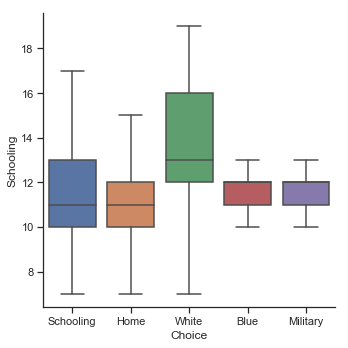

In [13]:
# outliers excluded in this plot, to include them showfliers=True
sns.catplot(x="Choice", y="Schooling", kind="box", data=df, showfliers=False)
plt.show()

##### Choice distribution by age as in Table 1
From the table below, we see that the vast majority of the sample, approximately 86%, is in school at age 16. 

In [14]:
table = pd.crosstab(index=df['Age'], columns=df['Choice'], margins=True)
table

Choice,Schooling,Home,White,Blue,Military,All
Age,,,,,,
16,1178,145,4,45,1,1373
17,1014,197,15,113,20,1359
18,561,296,92,331,70,1350
19,420,293,115,406,107,1341
20,341,273,149,454,113,1330
21,275,257,170,498,106,1306
22,169,212,256,559,90,1286
23,105,185,336,546,68,1240
24,65,112,284,416,44,921


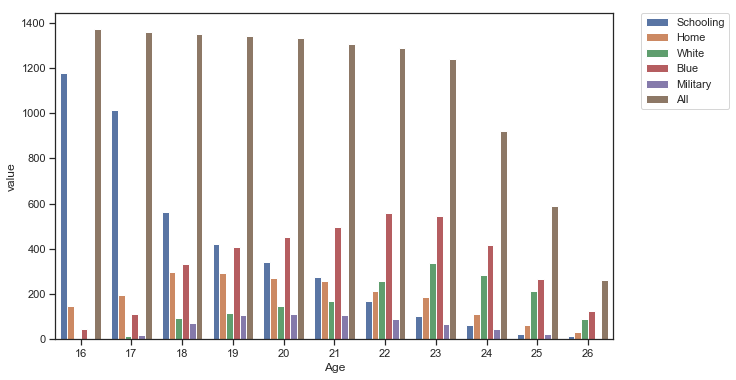

In [15]:
stacked_data = table.stack().reset_index().rename(columns={0:'value'})

#plot only age excluding the share of individuals per choice to visualise the withing age distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=stacked_data.Age.iloc[0:66], y=stacked_data.value, hue=stacked_data.Choice)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

##### Proportion of people choosing certain choices per period as in Table 3 (row 2)
These figures show the proportion choosing each choice from the choice set (unconditionally).

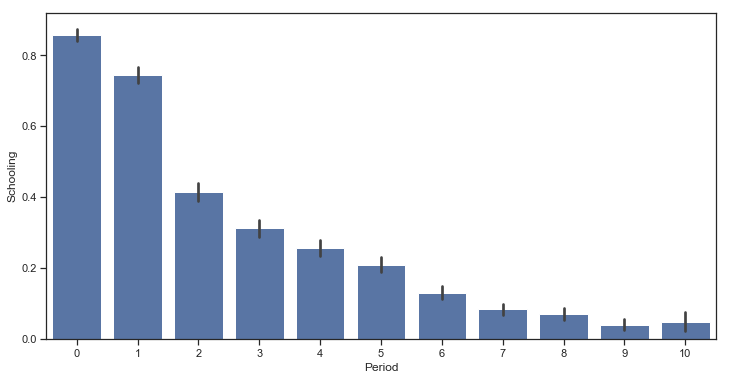

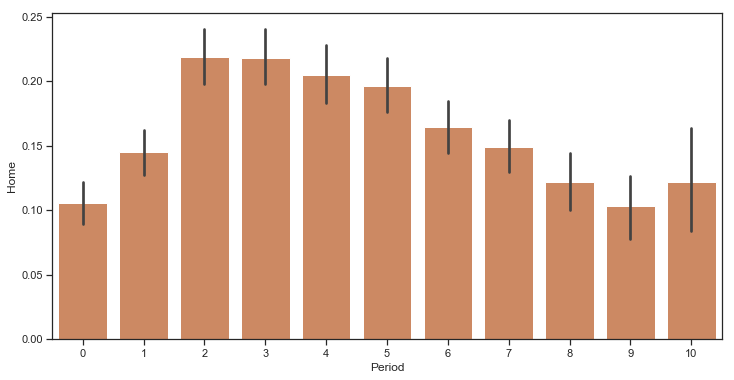

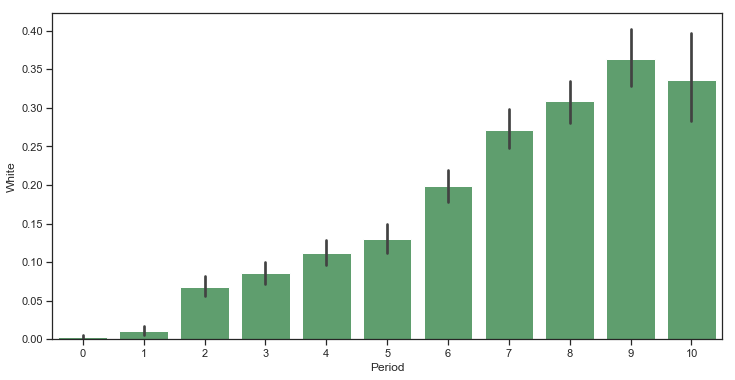

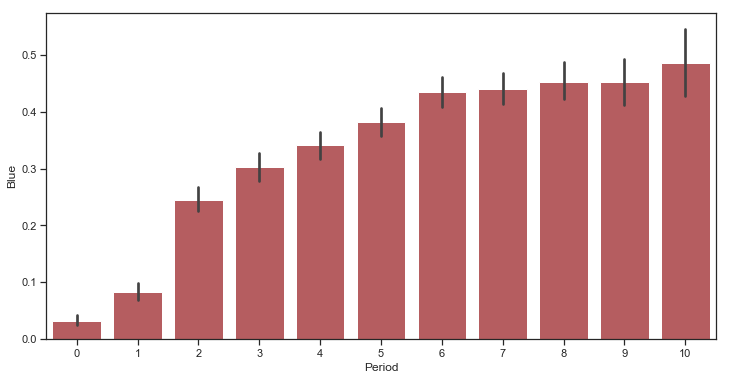

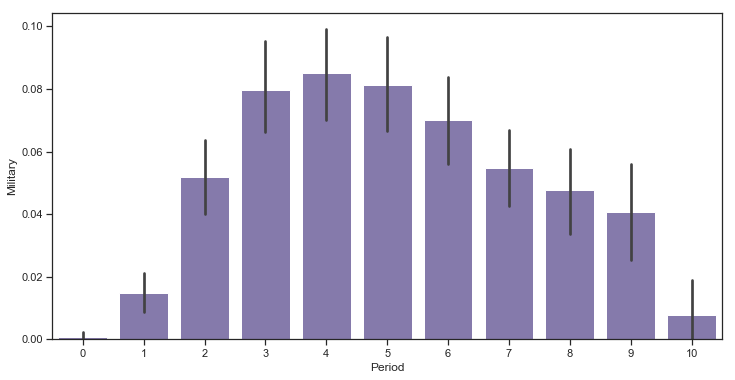

In [16]:
choice_names = ['Schooling', 'Home', 'White', 'Blue', 'Military']

for i, name in enumerate(choice_names):
    df_unindexed[name] = (df_unindexed['Choice'] == name).astype(float)
    sns.barplot(y=name, x='Period', data=df_unindexed, color=sns.color_palette()[i])
    ax.set_ylim(0, 1)
    plt.show()
    plt.close()

#### Occupational transitions
Below, l replicate Table 2 in the paper that shows one period transition rates, illustrating persistence in choice over periods.
My reproduced results deviate in some rows/columns from the results in the paper. A plausible explanation would be that what l have done below ensures precision in calculation i.e normalising row-wise) which may not have been the case when this paper was authored. Nonetheless, the results indicate the same as what has been documented in KW1997 with a few misaligned figures within the table.

In [17]:
data = df_unindexed.copy()
data['next_period'] = data['Period'] + 1
choice_data = df_unindexed[['Identifier', 'Period', 'Choice']]
choice_data.rename(columns={'Choice': 'NextChoice'}, inplace=True)

combined = pd.merge(
    left=data, 
    right=choice_data, 
    left_on=['Identifier', 'next_period'],
    right_on=['Identifier', 'Period'], 
    how='left', 
    suffixes=['', '_next'],
)
combined.drop(columns=['Period_next', 'next_period'], inplace=True)

# only first row is different from paper
tab_rows = (pd.crosstab(index=combined['Choice'], columns=combined['NextChoice'], normalize='index') * 100).round(1)

# all are different from paper because the normalization divides by sum over rows
tab_cols = (pd.crosstab(index=combined['Choice'], columns=combined['NextChoice'], normalize='columns') * 100).round(1)


# produces tables
# the first table (tab_rows) is the percentage of transitions from origin to destination i.e the row percentage
# the second table (tab_cols) is the percentage in a particular destination who started from each origin i.e column percentage
list_dfs = []
list_dfs.append( tab_rows )
list_dfs.append( tab_cols )
multi_column_df_display(list_dfs)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


NextChoice,Schooling,Home,White,Blue,Military
Choice,,,,,
Schooling,64.50,13.00,8.60,12.10,1.80
Home,9.80,47.20,8.10,31.30,3.70
White,5.70,6.30,67.40,19.90,0.70
Blue,3.40,12.40,9.90,73.40,0.90
Military,1.40,5.50,3.10,9.60,80.40
NextChoice,Schooling,Home,White,Blue,Military
Choice,,,,,
Schooling,87.50,27.50,20.30,13.20,11.00
Home,6.10,46.10,8.80,15.80,10.70


The heatmaps below show considerable immobility out of the home alternative, with the indication that observations that begin at home are also at home in the next period. The heatmaps also show substantial state dependence in occupation-specific employment for example, a majority of the people who are employed in white-collar occupations in one period are in white-collar occupations in the next, and the reverse is also true. 

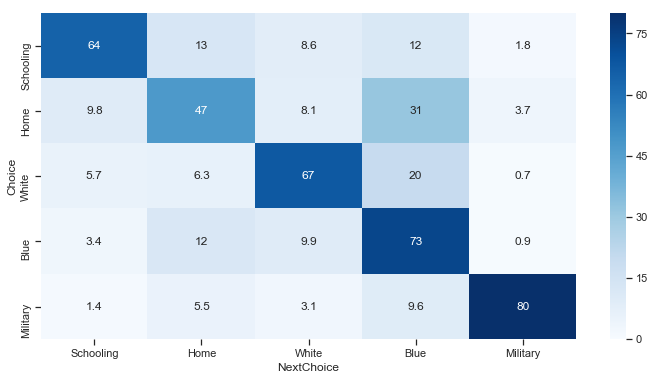

In [18]:
# this heatmap is the percentage of transitions from origin to destination i.e the row percentage
sns.heatmap(tab_rows, cmap='Blues', vmin=0, vmax=80, annot=True)
plt.show()

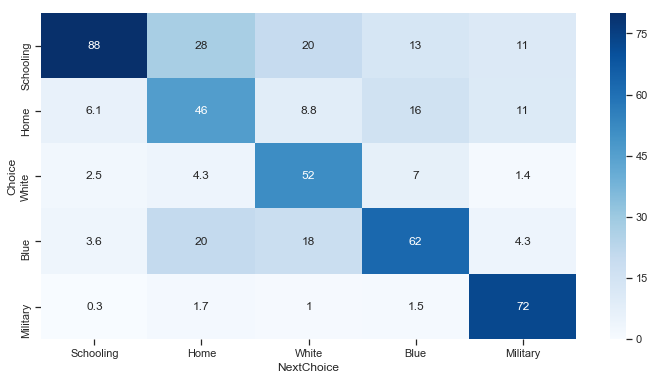

In [19]:
# the second table (tab_cols) is the percentage in a particular destination who started from each origin i.e column percentage
sns.heatmap(tab_cols, cmap='Blues', vmin=0, vmax=80, annot=True)
plt.show()

##### Age pattern of interoccupational transitions (not shown in paper)
Here l illustrate with period-wise heatmaps that, the age pattern of inter-occupational transitions differs considerably. After age 21 for example, transitions from white- to blue-collar occupations drop considerably.  

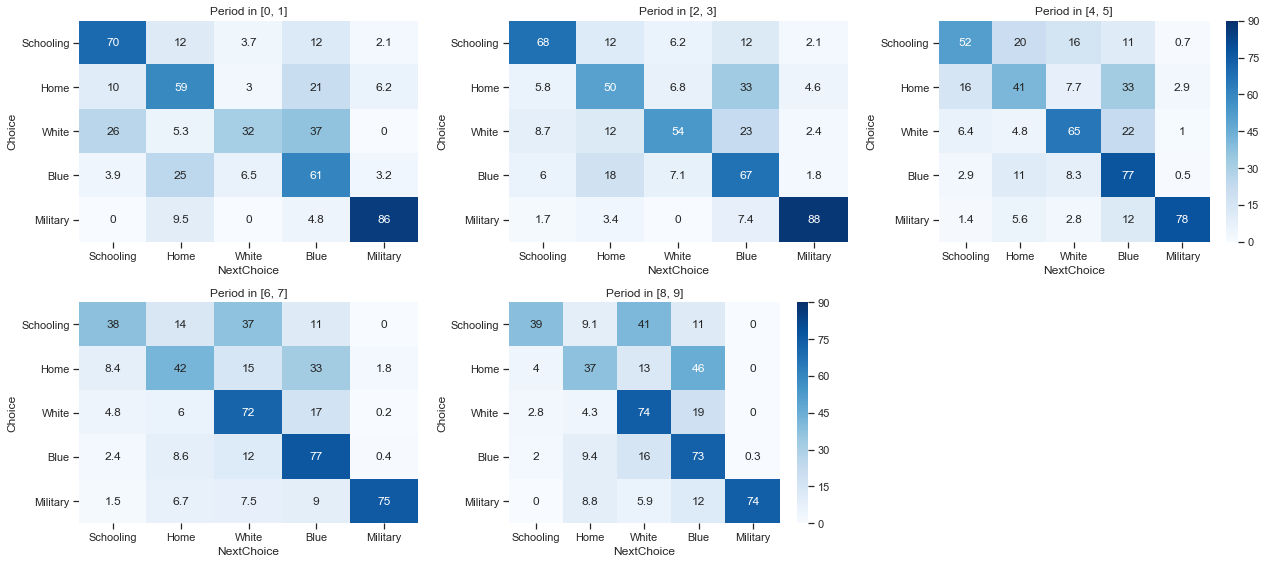

In [20]:
period_pairs = np.arange(10).reshape(5, 2).tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 8), )

for i, (pair, ax) in enumerate(zip(period_pairs, axes.reshape(-1))):
    period_df = combined.query('Period in {}'.format(pair))
    tab_rows = (pd.crosstab(index=period_df['Choice'], columns=period_df['NextChoice'], normalize='index') * 100).round(1)
    if i in [2, 4]:
        sns.heatmap(tab_rows, cmap='Blues', vmin=0, vmax=90, annot=True, ax=ax)
    else:
        sns.heatmap(tab_rows, cmap='Blues', vmin=0, vmax=90, annot=True, ax=ax, cbar=False)

        
    ax.set_title('Period in {}'.format(pair))
    plt.tight_layout()

axes.reshape(-1)[-1].remove()
plt.tight_layout()

The reverse transition, shown below, from white- to blue-collar jobs increases with age, supporting the notion from above.

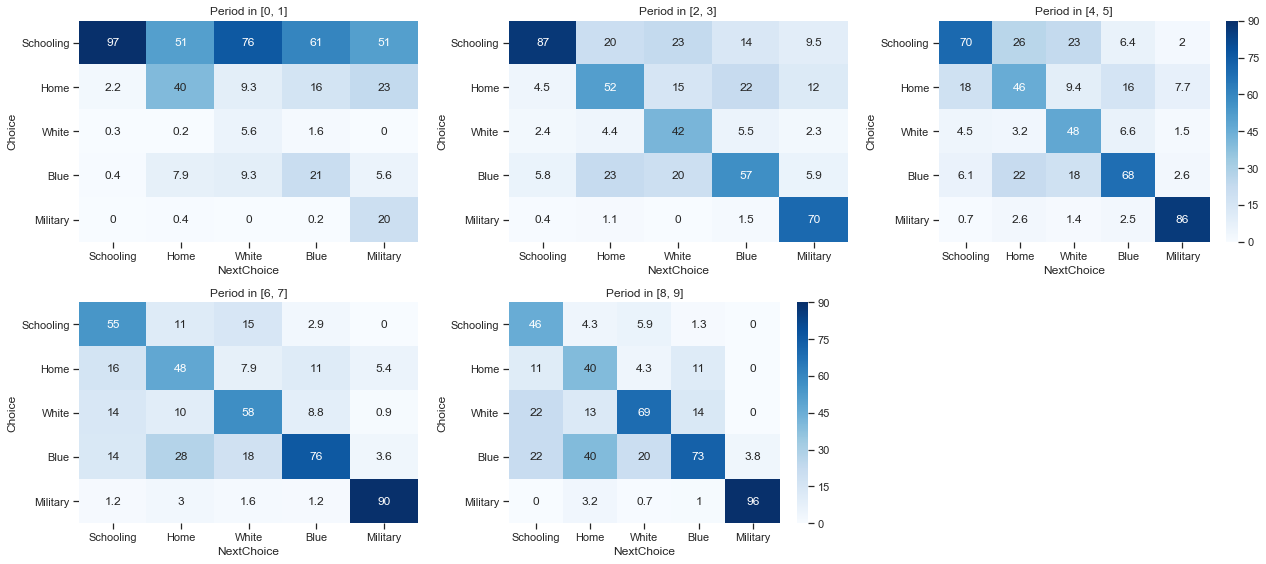

In [21]:
period_pairs = np.arange(10).reshape(5, 2).tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 8), )

for i, (pair, ax) in enumerate(zip(period_pairs, axes.reshape(-1))):
    period_df = combined.query('Period in {}'.format(pair))
    tab_cols = (pd.crosstab(index=period_df['Choice'], columns=period_df['NextChoice'], normalize='columns') * 100).round(1)
    if i in [2, 4]:
        sns.heatmap(tab_cols, cmap='Blues', vmin=0, vmax=90, annot=True, ax=ax)
    else:
        sns.heatmap(tab_cols, cmap='Blues', vmin=0, vmax=90, annot=True, ax=ax, cbar=False)

        
    ax.set_title('Period in {}'.format(pair))
    plt.tight_layout()

axes.reshape(-1)[-1].remove()
plt.tight_layout()

## Section 3: Replication of main result

#### Contribution to replicating KW1997

Here l make use of the functions l have written that calculate covariance matrices for hessian and jacobian matrices. These functions have since been encorporated into the [estimagic/inference](https://github.com/OpenSourceEconomics/estimagic/tree/likelihood_inference/estimagic/inference) folder for calculating standard errors. The tests for these functions can also be found in the [estimagic/tests/inference](https://github.com/OpenSourceEconomics/estimagic/tree/likelihood_inference/estimagic/tests/inference) folder.

Brief background on the methods l use to calculate standard errors - stress perfomance in small samples.

In [22]:
# Simulations for future periods

## Section 4: Discussion & Conclusion

## References